# Decoding the Surface Code

In this experiment, we decode the Surface code which protects a single qubit from all types of errors by using ``mdopt``. Here, we demonstrate direct-error input decoding, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. This pipeline is sufficient for threshold computation. In reality, the decoder could be shown a syndrome measurement, from which possible error patterns would be sampled. After each run, the algorithm yields a probability distribution over the Pauli operators (I, X, Z, Y) to apply to the encoded logical qubit. Hereafter, we assume an independent noise model as well as perfect syndrome measurements. We will create a Surface Code instance via the Hypergraph Product of two repetition codes since this construction yields a 2D lattice with stabilizers suitable for the Surface Code's structure.

In [1]:
import sys

sys.path.append("../")
sys.path.append("../..")

import numpy as np
import qecstruct as qec
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.mps.utils import create_custom_product_state, find_orth_centre
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)

from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
    apply_constraints,
    apply_bitflip_bias,
    apply_depolarising_bias,
    decode_custom,
    pauli_to_mps,
    decode_css,
    css_code_stabilisers,
    multiply_pauli_strings,
    map_distribution_to_pauli,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo

Let us first import the code from `qecstruct` and take a look at it. Here, we will be looking at a 3x3 system.

In [2]:
LATTICE_SIZE = 3
rep_code = qec.repetition_code(LATTICE_SIZE)
code = qec.hypergraph_product(rep_code, rep_code)
print(code)
print("The X logical: ", code.x_logicals_binary())
print("The Z logical: ", code.z_logicals_binary())

X stabilizers:
[0, 1, 9]
[1, 2, 10]
[3, 4, 9, 11]
[4, 5, 10, 12]
[6, 7, 11]
[7, 8, 12]
Z stabilizers:
[0, 3, 9]
[1, 4, 9, 10]
[2, 5, 10]
[3, 6, 11]
[4, 7, 11, 12]
[5, 8, 12]

The X logical:  [2, 5, 8]

The Z logical:  [0, 1, 2]



This quantum error correcting code is defined on $2 * L * (L-1) + 1 = 13$ (where $L$ is the lattice size and an extra qubit handles the boundary conditions) physical qubits and has $2$ logical operators because it encodes $1$ logical qubit. This means we will need $13*2 + 2 = 28$ sites in our MPS.

In [3]:
num_logicals = code.num_x_logicals() + code.num_z_logicals()
num_sites = 2 * len(code) + num_logicals

assert num_sites == 28
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zero state followed by decoding will return the all-zero state for the logical operators (the final logical operator will thus be identity operator). Thus, we start from the all-zero state for the error and the $|+\rangle$ state for the logicals.

In [4]:
error_state = "0" * (num_sites - num_logicals - 2) + "10"
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(
    string=state_string, tolerance=0, form="Right-canonical"
)

Here, we get the sites where the checks will be applied. We will need to construct MPOs using this data.

In [5]:
checks_x, checks_z = css_code_checks(code)
print("X checks:")
for check in checks_x:
    print(check)
print("Z checks:")
for check in checks_z:
    print(check)

X checks:
[2, 4, 20]
[4, 6, 22]
[8, 10, 20, 24]
[10, 12, 22, 26]
[14, 16, 24]
[16, 18, 26]
Z checks:
[3, 9, 21]
[5, 11, 21, 23]
[7, 13, 23]
[9, 15, 25]
[11, 17, 25, 27]
[13, 19, 27]


These lists display the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (a.k.a. the tensors' legs crossings) and boundary XOR constraints. In what follows, we define the list of these auxiliary tensors and the corresponding sites where they reside.

In [6]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

In [7]:
constraint_sites = css_code_constraint_sites(code)
print("Full X-check lists of sites:")
for string in constraint_sites[0]:
    print(string)
print("Full Z-check lists of sites:")
for string in constraint_sites[1]:
    print(string)

Full X-check lists of sites:
[[2], [4], [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20]]
[[4], [6], [5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], [22]]
[[8], [10, 20], [9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23], [24]]
[[10], [12, 22], [11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25], [26]]
[[14], [16], [15, 17, 18, 19, 20, 21, 22, 23], [24]]
[[16], [18], [17, 19, 20, 21, 22, 23, 24, 25], [26]]
Full Z-check lists of sites:
[[3], [9], [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21]]
[[5], [11, 21], [6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22], [23]]
[[7], [13], [8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23]]
[[9], [15], [10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24], [25]]
[[11], [17, 25], [12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26], [27]]
[[13], [19], [14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26], [27]]


Let us now again take a look at the logical operators.

In [8]:
print(code.x_logicals_binary())
print(code.z_logicals_binary())

[2, 5, 8]

[0, 1, 2]



We need to again translate them to our MPO language by changing the indices since we add the logical sites at the beginning of the MPS.

In [9]:
print(css_code_logicals(code)[0])
print(css_code_logicals(code)[1])

[[6, 12, 18]]
[[3, 5, 7]]


Now goes the same operation of adding sites where auxiliary tensors should be placed.

In [10]:
logicals_sites = css_code_logicals_sites(code)
print(css_code_logicals_sites(code)[0])
print(css_code_logicals_sites(code)[1])

[[[0], [6, 12], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17], [18]]]
[[[1], [3, 5], [2, 4, 6], [7]]]


Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

In [11]:
renormalise = True
sites_to_bias = list(range(num_logicals, num_sites))
error_mps = apply_bitflip_bias(
    mps=error_mps,
    prob_bias_list=0.1,
    sites_to_bias=sites_to_bias,
)

In [12]:
entropies, bond_dims = [], []

# for the X and the Z logicals
for i in [0, 1]:
    error_mps, entrps, bnd_dims = apply_constraints(
        error_mps,
        logicals_sites[i],
        logicals_tensors,
        chi_max=1e4,
        cut=0,
        renormalise=renormalise,
        strategy="Optimised",
        return_entropies_and_bond_dims=True,
    )
    entropies += entrps
    bond_dims += bnd_dims

# for the X and the Z checks
for i in [0, 1]:
    error_mps, entrps, bnd_dims = apply_constraints(
        error_mps,
        constraint_sites[i],
        constraints_tensors,
        chi_max=1e4,
        cut=0,
        renormalise=renormalise,
        strategy="Optimised",
        return_entropies_and_bond_dims=True,
    )
    entropies += entrps
    bond_dims += bnd_dims

100%|██████████| 6/6 [01:28<00:00, 14.79s/it]


Let us now take a look at how the bond dimensions and entropies behave throughout the decoding process while we apply the parity checks.

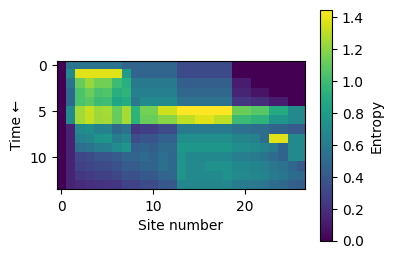

In [13]:
plt.figure(figsize=(4, 3))
plt.imshow(entropies, cmap="viridis")
plt.colorbar(label="Entropy")
plt.xlabel("Site number")
plt.ylabel("Time ←")
plt.show()

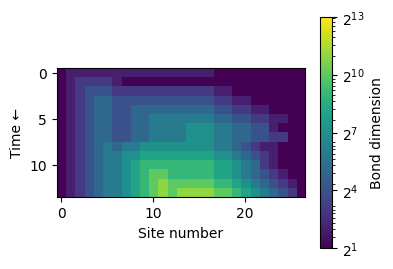

In [14]:
plt.figure(figsize=(4, 3))
plt.imshow(bond_dims, cmap="viridis", norm=LogNorm(vmin=2**1, vmax=2**13))
cbar = plt.colorbar(
    label="Bond dimension",
    format=FuncFormatter(lambda x, pos: f"$2^{{{int(np.log2(x))}}}$"),
    ticks=[2**i for i in range(1, 14, 3)],
)
plt.ylabel("Time ←")
plt.xlabel("Site number")
plt.show()

Let's now take a look at how the truncation error behaves for different bond dimension cutoffs. First, let's look at the bond dimensions of the MPS if we do not impose any truncation.

In [15]:
print(error_mps.bond_dimensions)

[2, 4, 8, 16, 32, 64, 64, 128, 256, 512, 1024, 2048, 1024, 2048, 2048, 2048, 2048, 1024, 1024, 512, 256, 128, 64, 32, 16, 8, 2]


In [16]:
bond_dims = [np.inf, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4]
inv_bond_dims = [1 / bd for bd in bond_dims]
errors = []
for chi in tqdm(bond_dims):
    errors.append(
        np.linalg.norm(
            error_mps.compress(
                chi_max=chi, renormalise=True, return_truncation_errors=True
            )[1]
        )
    )

100%|██████████| 11/11 [03:53<00:00, 21.24s/it]


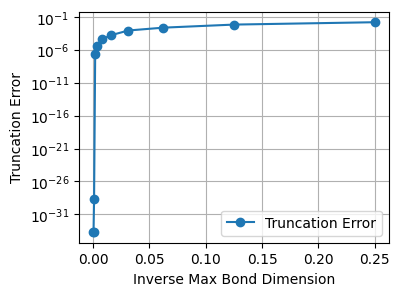

In [17]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, errors, marker="o", label="Truncation Error")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Truncation Error")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

Now, we marginalise over the message bits to get the probability distribution over the four possibilities of a logical operator: $I$, $X$, $Z$, $Y$.

In [18]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical = error_mps.marginal(sites_to_marginalise=sites_to_marginalise, renormalise=renormalise)
logical = logical.dense(flatten=True)
print(logical)

[0.91369578 0.19844496 0.34657426 0.07527223]


For the record, we're hunting for the most likely logical operator to be the identity operator. So that's it, we see the biggest probability assigned to the identity operator. Let's see how the probabilities of the four operators change as we change the bond dimension cutoff.

In [19]:
strategy = "Optimised"
logical_values = [[] for _ in range(4)]

for max_bond_dim in tqdm(bond_dims):
    error_state = "0" * (num_sites - num_logicals)
    logicals_state = "+" * num_logicals
    state_string = logicals_state + error_state
    error_mps = create_custom_product_state(
        string=state_string, tolerance=0, form="Right-canonical"
    )

    error_mps = apply_bitflip_bias(
        mps=error_mps,
        prob_bias_list=0.1,
        sites_to_bias=sites_to_bias,
    )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            logicals_sites[i],
            logicals_tensors,
            renormalise=renormalise,
            strategy=strategy,
            chi_max=max_bond_dim,
            cut=0,
            silent=True,
        )
    for i in [0, 1]:
        error_mps = apply_constraints(
            error_mps,
            constraint_sites[i],
            constraints_tensors,
            renormalise=renormalise,
            strategy=strategy,
            chi_max=max_bond_dim,
            cut=0,
            silent=True,
        )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = error_mps.marginal(sites_to_marginalise=sites_to_marginalise).dense(
        flatten=True, renormalise=renormalise, norm=1
    )

    for i in range(4):
        logical_values[i].append(logical[i])

100%|██████████| 11/11 [02:08<00:00, 11.67s/it]


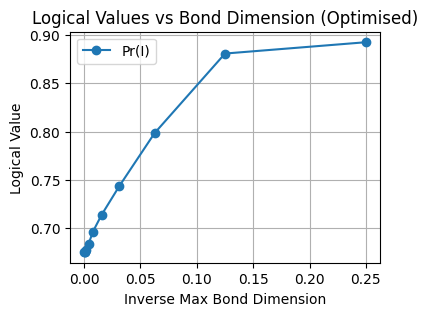

In [20]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[0], marker="o", label=f"Pr(I)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

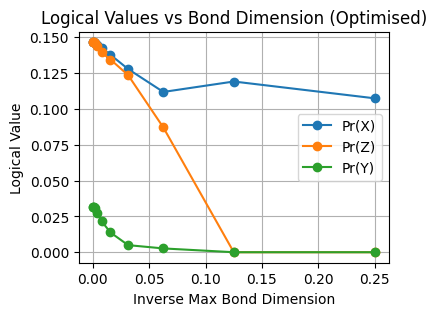

In [21]:
plt.figure(figsize=(4, 3))
plt.plot(inv_bond_dims, logical_values[1], marker="o", label=f"Pr(X)")
plt.plot(inv_bond_dims, logical_values[2], marker="o", label=f"Pr(Z)")
plt.plot(inv_bond_dims, logical_values[3], marker="o", label=f"Pr(Y)")
plt.xlabel("Inverse Max Bond Dimension")
plt.ylabel("Logical Value")
plt.title("Logical Values vs Bond Dimension (Optimised)")
plt.grid(True)
plt.legend()
plt.show()

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors. For this, we first generate all possible one-qubit errors and 20 two-qubit errors using `qecsim`.

In [22]:
one_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2))[:99]

In [23]:
one_qubit_outputs = [
    decode_css(
        code,
        error,
        renormalise=renormalise,
        silent=True,
        bias_prob=0,
    )
    for error in tqdm(one_qubit_paulis)
]
one_qubit_corrections_distribution = [output[0] for output in one_qubit_outputs]

  0%|          | 0/39 [00:00<?, ?it/s]/Users/aleksandrberezutskii/mdopt/mdopt/mps/canonical.py:1031: RuntimeWarning: invalid value encountered in true_divide
  self.tensors[self.orth_centre] /= orth_centre_norm
100%|██████████| 39/39 [00:00<00:00, 57.17it/s]


In [24]:
two_qubit_outputs = [
    decode_css(
        code,
        error,
        renormalise=renormalise,
        silent=True,
        bias_prob=0.001,
    )
    for error in tqdm(two_qubit_paulis[:20])
]
two_qubit_corrections_distribution = [output[0] for output in two_qubit_outputs]

100%|██████████| 20/20 [02:57<00:00,  8.86s/it]


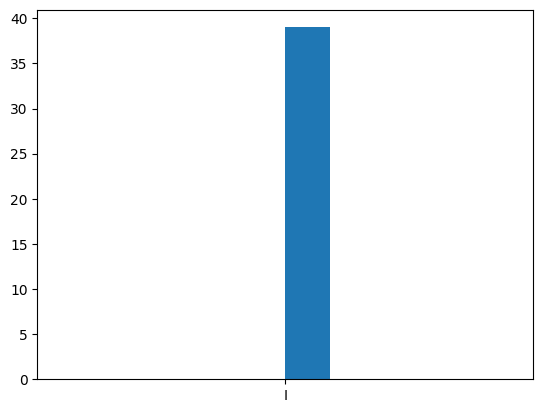

In [25]:
plt.hist(map_distribution_to_pauli(one_qubit_corrections_distribution))
plt.show()

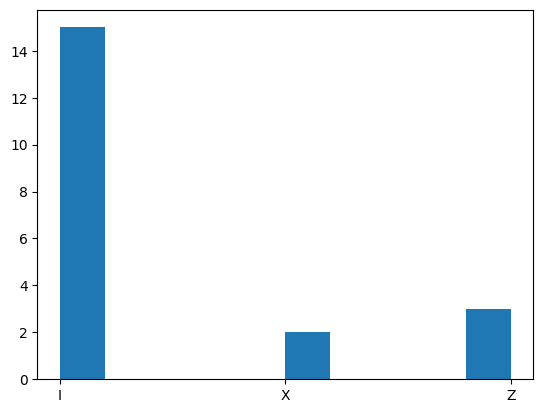

In [26]:
plt.hist(map_distribution_to_pauli(two_qubit_corrections_distribution))
plt.show()

Let's now check by hand that some of the decoder's nontrivial outputs are indeed correct. First of all, from all one-qubit errors we get the Identity operator which corresponds to the fact that the surface code of distance $d$ (equal to 3 in our case) corrects all the errors on up to $ \lfloor \frac{d-1}{2} \rfloor $ qubits. However, some of the two-qubit errors can be corrected as well. Let's check some of them. For this, let's take a look at the first 20 errors which result in the Identity logical operator as the output.

In [27]:
limit = 20
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "I":
        print(two_qubit_paulis[i])
    if i > limit:
        break

XXIIIIIIIIIII
XZIIIIIIIIIII
XYIIIIIIIIIII
ZZIIIIIIIIIII
ZYIIIIIIIIIII
YZIIIIIIIIIII
YYIIIIIIIIIII
XIXIIIIIIIIII
XIZIIIIIIIIII
ZIXIIIIIIIIII
ZIZIIIIIIIIII
YIXIIIIIIIIII
YIZIIIIIIIIII
YIYIIIIIIIIII
XIIZIIIIIIIII


To be able to track which parity check is triggered by which error, let's plot the tensor network we are building.

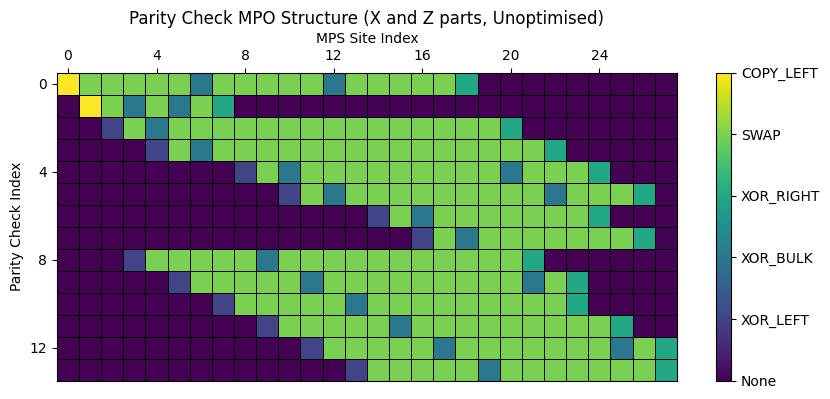

In [28]:
plot_parity_check_mpo(code)

We now want to dive a bit more into what is happening inside the decoder to be able to better understand the results. For example, the first error $(X_0 X_1)$ from the list above would trigger the first two $X$ parity checks. In the current setup the stabilisers are being set to $0$, which is the result of the fact that the $\text{XOR}$ tensors we use project out the inputs of odd (i.e., equal to $1$) parity. After applying the logical-operator MPOs and performing marginalization, the process yields a marginal distribution over codewords, each reflecting different parities of the logical operators.

Let's now take a look at the errors which result in the $X$ logical operator as the output.

In [29]:
for i, correction in enumerate(
    map_distribution_to_pauli(two_qubit_corrections_distribution)
):
    if correction == "X":
        print(two_qubit_paulis[i])

ZXIIIIIIIIIII
ZIYIIIIIIIIII


Similarly to the previous case, the first error $(Z_0 X_1)$ from the list above would trigger the first $X$ parity check which in its turn would trigger the $\text{XOR}$ tensor corresponding to the $X$ logical-operator MPO therefore the $X$ logical as the most likely output.

Finally, let's take a look at how the MPO order optimisation looks visually and test the truncation effects.

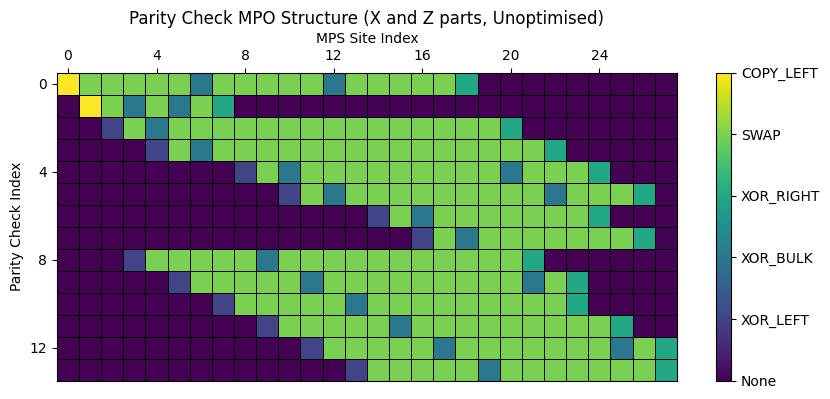

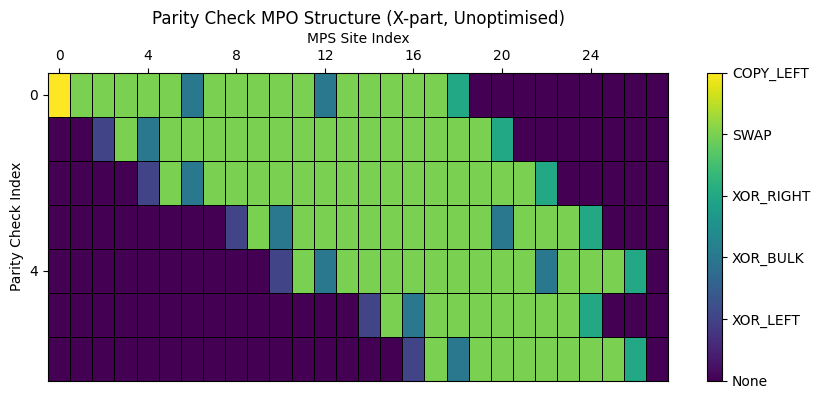

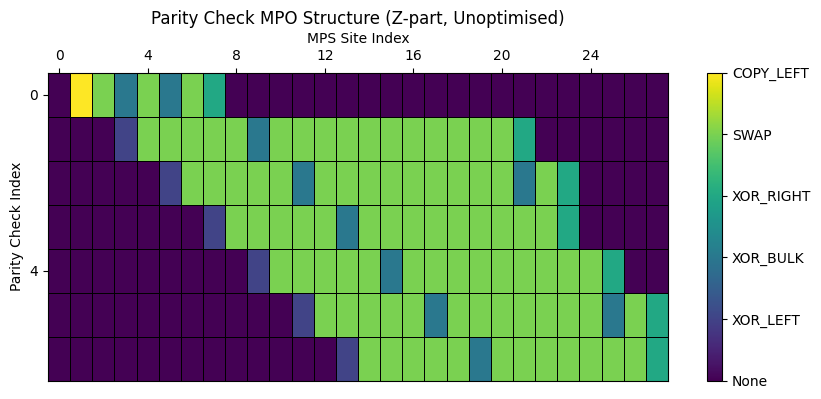

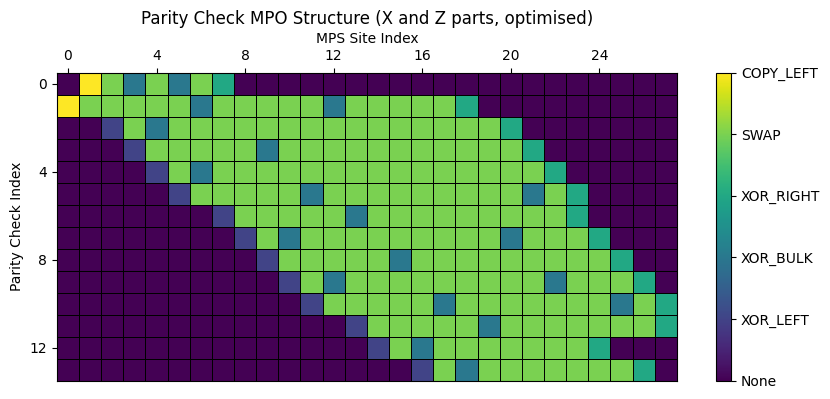

In [30]:
LATTICE_SIZE = 3
rep_code = qec.repetition_code(LATTICE_SIZE)
surface_code = qec.hypergraph_product(rep_code, rep_code)

mpo_matrix_full_unoptimised = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="both"
)

mpo_matrix_xpart = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="X"
)

mpo_matrix_zpart = plot_parity_check_mpo(
    surface_code, optimise_order=False, return_matrix=True, plot_type="Z"
)

mpo_matrix_full = plot_parity_check_mpo(
    surface_code, optimise_order=True, return_matrix=True, plot_type="both"
)

In [31]:
LATTICE_SIZE = 3
NUM_EXPERIMENTS = 5000

SEED = 123
seed_seq = np.random.SeedSequence(SEED)
errors = {}

max_bond_dims = [128, 64, 32, 16, 8]
error_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13]
failures_statistics = {}

rep_code = qec.repetition_code(LATTICE_SIZE)
surface_code = qec.hypergraph_product(rep_code, rep_code)

for ERROR_RATE in error_rates:
    errors[LATTICE_SIZE, ERROR_RATE] = []
    for l in range(NUM_EXPERIMENTS):
        rng = np.random.default_rng(seed_seq.spawn(1)[0])

        error = generate_pauli_error_string(
            len(surface_code),
            ERROR_RATE,
            rng=rng,
            error_model="Bitflip",
        )
        errors[LATTICE_SIZE, ERROR_RATE].append(error)

for CHI_MAX in max_bond_dims:
    print(f"CHI_MAX = {CHI_MAX}")
    for ERROR_RATE in tqdm(error_rates):
        failures = []

        for l in range(NUM_EXPERIMENTS):
            error = errors[LATTICE_SIZE, ERROR_RATE][l]
            _, success = decode_css(
                code=surface_code,
                error=error,
                chi_max=CHI_MAX,
                multiply_by_stabiliser=False,
                bias_type="Bitflip",
                bias_prob=0.1,
                tolerance=0,
                cut=0,
                renormalise=True,
                silent=True,
                contraction_strategy="Optimised",
            )
            failures.append(1 - success)

        failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = failures

CHI_MAX = 128


100%|██████████| 7/7 [26:34<00:00, 227.80s/it]


CHI_MAX = 64


100%|██████████| 7/7 [24:18<00:00, 208.34s/it]


CHI_MAX = 32


100%|██████████| 7/7 [36:10<00:00, 310.04s/it]


CHI_MAX = 16


100%|██████████| 7/7 [10:17<00:00, 88.18s/it] 


CHI_MAX = 8


100%|██████████| 7/7 [06:57<00:00, 59.61s/it]


In [32]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )
        error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = sem(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )

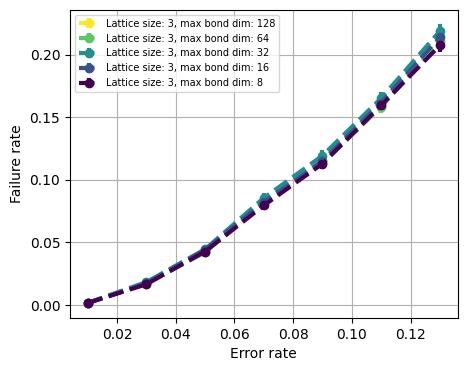

In [33]:
plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [
            failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"Lattice size: {LATTICE_SIZE}, max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()
plt.show()

Great, so, we see the convergence in bond dimension (given bitflip noise, we converege to optimal decoding at the bond dimension equal to $2^6$ where $6$ is the maximum number of leg crossings encountered while applying MPOs, thus the curves with bond dimensions $2^6$ and $2^7$ are identically the same). Besides, we see how the curve moves to the right as we increase the bond dimension cutoff which is expected behaviour.

Let us now look at what happens if we scale the system.

In [ ]:
errors = {}
failures_statistics = {}
failure_rates = {}
error_bars = {}
lattice_sizes = [7, 5, 3]

for LATTICE_SIZE in lattice_sizes:
    NUM_EXPERIMENTS = 5000
    SEED = 123

    # Parameters
    tolerances = [0]
    biases = [0.1]
    cuts = [0]
    max_bond_dims = [20]
    error_rates = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13]

    # Initialize
    seed_seq = np.random.SeedSequence(SEED)

    # Generate the code
    rep_code = qec.repetition_code(LATTICE_SIZE)
    surface_code = qec.hypergraph_product(rep_code, rep_code)

    # Generate Pauli errors for each error rate
    for ERROR_RATE in error_rates:
        errors[LATTICE_SIZE, ERROR_RATE] = []
        for l in range(NUM_EXPERIMENTS):
            rng = np.random.default_rng(seed_seq.spawn(1)[0])

            error = generate_pauli_error_string(
                len(surface_code),
                ERROR_RATE,
                rng=rng,
                error_model="Bitflip",
            )
            errors[LATTICE_SIZE, ERROR_RATE].append(error)

    # Run decoding experiments for each combination of bias, tolerance, and chi_max
    for CHI_MAX in max_bond_dims:
        for BIAS in biases:
            for TOLERANCE in tolerances:
                for CUT in cuts:
                    for ERROR_RATE in error_rates:
                        failures = []

                        for l in tqdm(
                            range(NUM_EXPERIMENTS),
                            desc=f"Error rate={ERROR_RATE}, Bias={BIAS}, Tol={TOLERANCE}, Cut={CUT}, Chi={CHI_MAX}, L={LATTICE_SIZE}",
                        ):
                            error = errors[LATTICE_SIZE, ERROR_RATE][l]
                            try:
                                _, success = decode_css(
                                    code=surface_code,
                                    error=error,
                                    chi_max=CHI_MAX,
                                    multiply_by_stabiliser=False,
                                    bias_type="Bitflip",
                                    bias_prob=BIAS,
                                    cut=CUT,
                                    tolerance=TOLERANCE,
                                    renormalise=True,
                                    silent=True,
                                    contraction_strategy="Optimised",
                                )
                                failures.append(1 - success)
                            except Exception as e:
                                print(
                                    f"Error during decoding: {e}"
                                )
                                failures.append(np.nan)

                        # Store failures statistics
                        failures_statistics[
                            LATTICE_SIZE, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT
                        ] = failures

Error rate=0.01, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [27:49<00:00,  1.20it/s]
Error rate=0.03, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [44:07<00:00,  1.32s/it]
Error rate=0.05, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [48:40<00:00,  1.46s/it]
Error rate=0.07, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [50:01<00:00,  1.50s/it]
Error rate=0.09, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [1:03:56<00:00,  1.92s/it]
Error rate=0.11, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [49:55<00:00,  1.50s/it]
Error rate=0.13, Bias=0.1, Tol=0, Cut=0, Chi=20, L=7: 100%|██████████| 2000/2000 [50:21<00:00,  1.51s/it]
Error rate=0.01, Bias=0.1, Tol=0, Cut=0, Chi=20, L=5: 100%|██████████| 2000/2000 [03:43<00:00,  8.96it/s]
Error rate=0.03, Bias=0.1, Tol=0, Cut=0, Chi=20, L=5: 100%|██████████| 2000/2000 [07:56<00:00,  4.19it/s]
Error rate=0.05, Bias=0.1, Tol=0, Cut=0, Chi

In [35]:
for LATTICE_SIZE in lattice_sizes:
    for CHI_MAX in max_bond_dims:
        for BIAS in biases:
            for TOLERANCE in tolerances:
                for CUT in cuts:
                    for ERROR_RATE in error_rates:
                        key = (LATTICE_SIZE, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT)
                        failure_rates[key] = np.nanmean(failures_statistics[key])
                        error_bars[key] = sem(failures_statistics[key], nan_policy="omit")

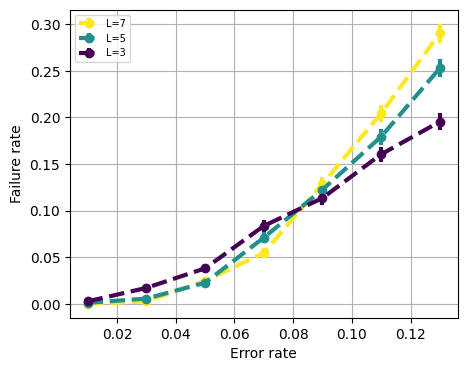

In [37]:
CHI_MAX, BIAS, TOLERANCE, CUT = 20, 0.1, 0, 0

plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(lattice_sizes) - 1)

for index, lattice_size in enumerate(lattice_sizes):
    plt.errorbar(
        error_rates,
        [
            failure_rates[lattice_size, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[lattice_size, CHI_MAX, ERROR_RATE, BIAS, TOLERANCE, CUT]
            for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"L={lattice_size}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )
    plt.legend(fontsize=7)

plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()
plt.show()